In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/dataset
%rm -rf -d *.jpeg

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1QgidBkm7u-yJfIgTviRs4w0rCDxGfd4u/dataset


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#LOAD THE CSV FILES
beats_encoding_per_vid= pd.read_csv('./beats_encoding_per_vid_normalized_0.3.csv', header=None)
scenes_per_vid= pd.read_csv('./scenes_per_vid_normalized_0.3.csv', header=None)
lengths= pd.read_csv('./lengths_normalized.csv', header=None)

beats_encoding_per_vid = beats_encoding_per_vid.values.tolist()
scenes_per_vid = scenes_per_vid.values.tolist()
scenes_per_vid = [list(filter(lambda x: not math.isnan(x), sublist)) for sublist in scenes_per_vid]
lengths = lengths.values.tolist()

In [ ]:
# Loop over each element in the array and convert strings to lists of floats
new_array = []
for row in beats_encoding_per_vid:
    new_row = []
    for element in row:
        if isinstance(element, str):
            # Split the string and convert each substring to a float
            new_element = [float(x) for x in element[1:-1].split(',')]
            new_row.append(new_element)
        else:
          continue
    new_array.append(new_row)

beats_encoding_per_vid = new_array

for i in range(len(beats_encoding_per_vid)):
  del beats_encoding_per_vid[i][lengths[i][0] : ]

In [ ]:
import math
for i in range(len(scenes_per_vid)):
  scenes_per_vid[i] = [x for x in scenes_per_vid[i] if x == 1 or x ==0]

len(scenes_per_vid)

190

In [ ]:
# for el in scenes_per_vid:
#   print(el)

In [ ]:
sum = 0
for el in scenes_per_vid:
  sum += len(el)

avg = sum / len(scenes_per_vid)

print(avg)

41.01052631578948


In [ ]:
X = []
Y = []

maxlen = int(avg)

for i in range(len(scenes_per_vid)):
  edits = np.array(scenes_per_vid[i])

  beats = beats_encoding_per_vid[i]

  n_samples = len(beats)

  place_holder = []

  for i in range(0,min(maxlen,len(beats))):
      place_holder.append(np.array(beats[i]))
      X.append(list(place_holder))
      Y.append(edits[i])

total_samples = len(X)

In [ ]:
del edits
del beats
del place_holder
del lengths
del scenes_per_vid
del beats_encoding_per_vid

In [ ]:
n_features = len(X[0][0])

X_padded = np.zeros((total_samples, maxlen, n_features), dtype=np.float32)

for i,el in enumerate(X):
  for j,el2 in enumerate(X[i]):
    if j < 40:
      X_padded[i][j] = X[i][j]

In [ ]:
len(X_padded[0][0])

1026

In [ ]:
del X

In [ ]:
print(X_padded.shape)

(4878, 40, 1026)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_padded,Y ,random_state=900, test_size=0.2, shuffle=False)

In [ ]:
x_train = tf.constant(x_train)
y_train = np.array(y_train)

x_test = tf.constant(x_test)
y_test = np.array(y_test)

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(3902, 40, 1026)
(3902,)
(976, 40, 1026)
(976,)


In [ ]:
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.losses import BinaryFocalCrossentropy
from keras.optimizers import Adam, RMSprop
from keras.metrics import BinaryAccuracy, AUC
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

In [ ]:
model = Sequential([
    keras.Input(shape=(None,1026)),
    layers.Masking(mask_value = 0.0),
    layers.LSTM(256, return_sequences = True, activation='relu'),
    layers.Dropout(0.5),
    layers.LSTM(256, return_sequences = True, activation='relu'),
    layers.Dropout(0.5),
    layers.LSTM(256, return_sequences = False, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1),
])


pr_auc = tf.keras.metrics.AUC()

optimizer = Adam(learning_rate=0.001)

loss = BinaryCrossentropy(from_logits=True)
metrics = [pr_auc]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(x_train, y_train, epochs = 300, batch_size = 256, verbose = 2, validation_data=(x_test, y_test)) 

In [ ]:
model.evaluate(x_test,y_test, verbose = 2, batch_size = 32)

31/31 - 1s - loss: 29.2126 - auc_2: 0.5074 - 937ms/epoch - 30ms/step


[29.21260643005371, 0.5074223875999451]

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'auc_2', 'val_loss', 'val_auc_2'])


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3902, 40, 1026)
(3902,)
(976, 40, 1026)
(976,)


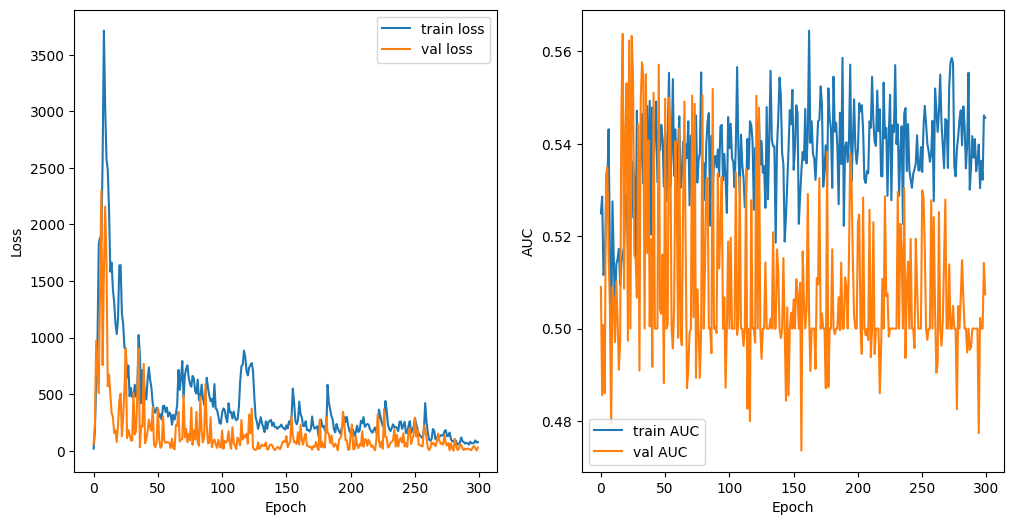

In [ ]:
import matplotlib.pyplot as plt

# Plot the train/validation loss and AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['auc_2'], label='train AUC')
ax2.plot(history.history['val_auc_2'], label='val AUC')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.legend()

plt.show()


In [ ]:
#Save the weights of the model
PATH = './Weights_folder/TikTok_Base_LSTM_weights'
# model.save_weights(PATH)

In [ ]:
model.load_weights(PATH)

In [ ]:
logits = model.predict(x_test)
y_pred = np.where(logits >= 0.1, 1, 0)
y_pred = np.argmax(y_pred, axis=1)
y_pred

In [ ]:
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(y_true,y_pred)

In [ ]:
balanced_acc